Imports:

In [1]:
from train_for_real import *
import pickle

# #Scientific computing 
# import numpy as np
# #Pytorch packages
# import torch
from torch import nn
import torch.optim as optim
from tensorboardX import SummaryWriter
#Visulization
#from tqdm import tqdm
from tqdm.notebook import tqdm
import monai
# finetuneSAM\models\sam_LoRa.py
from finetuneSAM.models.sam_LoRa import LoRA_Sam


c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_5m_224 in registry with finetuneSAM.models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit

In [2]:
from finetuneSAM.cfg import parse_args
#Fine-Tune Sam
args =  parse_args()


# setting if_mask_decoder_adapter = True puts adapters inside 2-way transformer blocks
# this does not change the number of decoder 2-way transformer blocks (def = 2)
# decoder_adapt_depth denotes how many of the two 2-way transformer blocks are adapted


# setting if_encoder_adapter = True puts adapters inside TinyViTBlocks in the encoder
# this does not change the number of encoder TinyViTBlocks (def = 4)
# encoder_adapt_depth (e.g. [1,2]) denotes how deep blocks will be adapted


# parser.add_argument('-if_update_encoder', type=bool, default=False , help='if update_image_encoder')
# parser.add_argument('-if_encoder_adapter', type=bool, default=False , help='if add adapter to encoder')

# parser.add_argument('-encoder-adapter-depths', type=list, default=[0,1,10,11] , help='the depth of blocks to add adapter')
# parser.add_argument('-if_mask_decoder_adapter', type=bool, default=False , help='if add adapter to mask decoder')
# parser.add_argument('-decoder_adapt_depth', type=int, default=2, help='the depth of the decoder adapter')

# parser.add_argument('-if_encoder_lora_layer', type=bool, default=False , help='if add lora to encoder')
# parser.add_argument('-if_decoder_lora_layer', type=bool, default=False , help='if add lora to decoder')
# parser.add_argument('-encoder_lora_layer', type=list, default=[0,1,10,11] , help='the depth of blocks to add lora, if [], it will add at each layer')

#    parser.add_argument('-finetune_type', type=str, default='adapter', help='normalization type, pick among vanilla,adapter,lora')

args.finetune_type = "adapter"


#args.finetune_type = "vanilla"
#args.finetune_type = "adapter"# "vanilla"
#args.if_mask_decoder_adapter = True


# # #decoder
# # args.finetune_type = "adapter"
# # args.if_mask_decoder_adapter = True

#encoder
args.finetune_type = "adapter"
args.if_encoder_adapter = True
args.if_update_encoder = True

# #lora decoder
# args.finetune_type = "lora"
# args.if_decoder_lora_layer = True






args.num_cls = 3




In [3]:
sam = load_model(args)


with open('data_w_ps.pkl', 'rb') as file:
    data = pickle.load(file)

train_points = len(data['image'])
checkpoints_path = 'checkpoints'


val_percentage = 0.15
val_points = int(train_points*val_percentage)
train_points = train_points - val_points
print('Train points:',train_points)

val_data = {"image":[],"mask":[],"points":[],"p_labels":[]}
for i in range(val_points):
    rnd_indx = np.random.randint(0,len(data["image"])-1)
    val_data["image"].append(data["image"].pop(rnd_indx))
    val_data["mask"].append(data["mask"].pop(rnd_indx))
    val_data['points'].append(data['points'].pop(rnd_indx))
    val_data['p_labels'].append(data['p_labels'].pop(rnd_indx))
    
train_data = data

train_data = EyeData(train_data)

val_data = EyeData(val_data)




if args.finetune_type == 'adapter':
        for n, value in sam.named_parameters():
            if "Adapter" not in n: # only update parameters in adapter
                value.requires_grad = False
        print('if update encoder:',args.if_update_encoder)
        print('if image encoder adapter:',args.if_encoder_adapter)
        print('if mask decoder adapter:',args.if_mask_decoder_adapter)
        if args.if_encoder_adapter:
            print('added adapter layers:',args.encoder_adapter_depths)
elif args.finetune_type == 'lora':
    print('if update encoder:',args.if_update_encoder)
    print('if image encoder lora:',args.if_encoder_lora_layer)
    print('if mask decoder lora:',args.if_decoder_lora_layer)
    for n, value in sam.named_parameters():
        value.requires_grad = False
    sam = LoRA_Sam(args,sam,r=4).sam

sam.to('cuda')



sammy = Sammy(sam, (512,512))

c:\KU\SamPeft\finetuneSAM\models\sam\build_sam.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Train points: 68
if update encoder: True
if image encoder adapter: True
if mask decoder adapter: False
added adapter layers: [0, 1, 10, 11]


In [ ]:
def adjust_lr(losses, rates):
    # if improvement is less than 0.1% stop training
    # 0.30 , 0.25
    l3 = losses[-1]
    l2 = losses[-2]
    l1 = losses[-3]
    d1 = l2 - l1
    d2 = l3 - l2
    mean_diff = (d1 + d2) / 2
    #print('mean_diff:',mean_diff)
    x = abs(mean_diff)

    last_loss = losses[-1]
    curr_rate = rates[-1]
    
    regress = mean_diff > 0


    is_lvl1 = (regress or  x < 0.01  ) and ( last_loss > 0.5 )
    is_lvl2 = (regress or  x < 0.005  ) and ( ( (last_loss < 0.5) and  (last_loss > 0.4 ) ) )
    is_lvl3 = (regress or  x < 0.003  ) and ( ( (last_loss < 0.4) and  (last_loss > 0.35) ) )
    is_lvl4 = (regress or  x < 0.002  ) and ( ( (last_loss < 0.35)  ) )


    if is_lvl1:
        print("Level 1 adjustment: ",x, ' < ',0.01)
        if curr_rate > 0.0005:
            return curr_rate * 0.5
        else:
            return 0.01
    elif is_lvl2:
        print("Level 2 adjustment: ",x, ' < ',0.005)
        if curr_rate > 0.0001:
            return curr_rate * 0.25
        else:
            return 0.005
    elif is_lvl3:
        print("Level 3 adjustment: ",x, ' < ',0.003)
        if curr_rate > 0.00005:
            return curr_rate * 0.1
        else:
            return 0.001
    elif is_lvl4:
        print("Level 4 adjustment: ",x, ' < ',0.002)
        if curr_rate > 0.00001:
            return curr_rate * 0.1
        else:
            return 0.0005
    else:
        print("No adjustment: ",x)
        return curr_rate

    
    
    

In [5]:
# print leanable parameters with grad true
for n, value in sam.named_parameters():
    if value.requires_grad:
        print(n)


image_encoder.layers.1.blocks.0.MLP_Adapter.D_fc1.weight
image_encoder.layers.1.blocks.0.MLP_Adapter.D_fc1.bias
image_encoder.layers.1.blocks.0.MLP_Adapter.D_fc2.weight
image_encoder.layers.1.blocks.0.MLP_Adapter.D_fc2.bias
image_encoder.layers.1.blocks.0.Space_Adapter.D_fc1.weight
image_encoder.layers.1.blocks.0.Space_Adapter.D_fc1.bias
image_encoder.layers.1.blocks.0.Space_Adapter.D_fc2.weight
image_encoder.layers.1.blocks.0.Space_Adapter.D_fc2.bias
image_encoder.layers.1.blocks.1.MLP_Adapter.D_fc1.weight
image_encoder.layers.1.blocks.1.MLP_Adapter.D_fc1.bias
image_encoder.layers.1.blocks.1.MLP_Adapter.D_fc2.weight
image_encoder.layers.1.blocks.1.MLP_Adapter.D_fc2.bias
image_encoder.layers.1.blocks.1.Space_Adapter.D_fc1.weight
image_encoder.layers.1.blocks.1.Space_Adapter.D_fc1.bias
image_encoder.layers.1.blocks.1.Space_Adapter.D_fc2.weight
image_encoder.layers.1.blocks.1.Space_Adapter.D_fc2.bias
image_encoder.layers.2.blocks.0.MLP_Adapter.D_fc1.weight
image_encoder.layers.2.blocks.0

In [6]:
# TRAINING LOOP
b_lr = 0.01
if args.if_warmup:
    b_lr = 0.01

epochs = 64
batch_size = 5

optimizer = optim.AdamW(sam.parameters(), lr=b_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7) #learning rate decay

criterion1 = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')
criterion2 = nn.BCEWithLogitsLoss()
iter_num = 0
max_iterations = epochs * train_points
writer = SummaryWriter(checkpoints_path + '/log')

pbar = tqdm(range(epochs))
val_largest_dsc = 0
last_update_epoch = 0
print('Start training')

mask_downscale_f = Upsample(scale_factor=0.5)

#args.if_warmup = True
args.warmup_period = 20


is_warmup_over = not args.if_warmup
train_data.divide_into_batches(batch_size)
print("Number of batches: ",len(train_data.batches))
print("Batches pr epoch: ",len(train_data.batches))




lrs = []
lss = []


for epoch in pbar:
    print('Epoch num {}'.format(epoch))
    sam.train()
    train_loss = 0
    train_data.divide_into_batches(batch_size)

    
    if args.if_warmup and epoch < args.warmup_period:
            
            # s = ((2*args.warmup_period)+1) / (epoch+1 )
            # scalar = min(max(s,2.5),8)
            l = [0.9,0.8,0.75,0.72,0.7,0.68,0.66,0.64,0.62,0.6,0.58,0.56,0.54,0.52,0.5,0.48,0.46,0.44,0.42,0.4]
            scalar = l[epoch]
            lr_ = b_lr * (5*scalar)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
            # set also for scheduler
            for param_group in scheduler.optimizer.param_groups:
                param_group['lr'] = lr_

    elif args.if_warmup and epoch == args.warmup_period:
        is_warmup_over = True
        b_lr = 0.01
        print('**Warmup is over**')
        for param_group in optimizer.param_groups:
            param_group['lr'] = b_lr
        # set also for scheduler
        for param_group in scheduler.optimizer.param_groups:
            param_group['lr'] = b_lr


    b_bar = tqdm(range(len(train_data.batches)))

    for i in b_bar:

        batch = train_data.batches[i]
        imgs = batch['image']
        msks = batch['mask']
        points = batch['points']
        labels = batch['p_labels']


        if args.if_update_encoder:
            img_emb = sammy.encode_img(imgs)
        else:
            with torch.no_grad():
                img_emb = sammy.encode_img(imgs)
        
        sparse_emb, dense_emb = sammy.encode_promts(points=points, labels=labels)




        _,pred = sammy.decode_features(img_emb, sparse_emb, dense_emb)

        


        msks = torch.tensor(msks).float().cuda()
        # from Bx512x512 to Bx1x512x512
        msks = msks.unsqueeze(1)
        # from 512x512 to 256x256
        msks = mask_downscale_f(msks)
        
        
        
        loss_dice =  criterion1(pred,msks)
        loss_ce = criterion2(pred,msks)
        loss =  loss_dice + loss_ce


        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item()
        iter_num+=1

        if is_warmup_over:
            writer.add_scalar('info/lr', scheduler.get_last_lr(), iter_num)
        else:
            writer.add_scalar('info/lr', lr_, iter_num)
        writer.add_scalar('info/total_loss', loss, iter_num)
        writer.add_scalar('info/loss_ce', loss_ce, iter_num)
        #writer.add_scalar('info/loss_dice', loss_dice, iter_num)
    

    

    train_loss /= (i+1)
    #pbar.set_description('Epoch num {}| train loss {} | lr {} \n'.format(epoch,train_loss,optimizer.param_groups[0]['lr']))
    print('Epoch num {}| train loss {} | lr_opt {} | lr_sch {}\n'.format(epoch,train_loss,optimizer.param_groups[0]['lr'],scheduler.get_last_lr()))

    lss.append(train_loss)
    lrs.append(optimizer.param_groups[0]['lr'])
    if len(lss) > 3:
        b_lr = adjust_lr(lss, lrs)
        #print("adjust_lr:",b_lr)
        if b_lr != optimizer.param_groups[0]['lr']:
            for param_group in optimizer.param_groups:
                param_group['lr'] = b_lr
            lss = []
            lrs = []
        else:
            lss.pop(0)
            lrs.pop(0)

        
        


    # if is_warmup_over:
    #     scheduler.step()



    if epoch > 5 and not epoch%2==0:
        
        eval_loss=0
        dsc = 0
        sam.eval()
        with torch.no_grad():
            train_data.divide_into_batches(batch_size)
            for i in range(len(train_data.batches)):
                batch = train_data.batches[i]
                imgs = batch['image']
                msks = batch['mask']
                points = batch['points']
                labels = batch['p_labels']

                img_emb = sammy.encode_img(imgs)
                
                sparse_emb, dense_emb = sammy.encode_promts(points=points, labels=labels)
                _,pred = sammy.decode_features(img_emb, sparse_emb, dense_emb)

                msks = torch.tensor(msks).float().cuda()
                # from Bx512x512 to Bx1x512x512
                msks = msks.unsqueeze(1)
                # from 512x512 to 256x256
                msks = mask_downscale_f(msks)
                
                loss_dice =  criterion1(pred,msks)
                loss_ce = criterion2(pred,msks)
                loss =  loss_dice + loss_ce
                
                eval_loss +=loss.item()
                dsc_batch = 1-loss_dice
                dsc+=dsc_batch
                #print(dsc_batch)

            eval_loss /= (i+1)
            dsc /= (i+1)
            
            writer.add_scalar('eval/loss', eval_loss, epoch)
            writer.add_scalar('eval/dice', dsc, epoch)
            
            print('Eval Epoch num {} | val loss {} | dsc {} \n'.format(epoch,eval_loss,dsc))
            if dsc>val_largest_dsc:
                val_largest_dsc = dsc
                last_update_epoch = epoch
                print('largest DSC now: {}'.format(dsc))
                torch.save(sam.state_dict(),checkpoints_path + '/checkpoint_best.pth')
            elif (epoch-last_update_epoch)>20:
                # the network haven't been updated for 20 epochs
                print('Training finished###########')
                break
writer.close()

  0%|          | 0/64 [00:00<?, ?it/s]

Start training
Number of batches:  14
Batches pr epoch:  14
Epoch num 0


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 0| train loss 0.9714833157403129 | lr_opt 0.01 | lr_sch [0.01]

Epoch num 1


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 1| train loss 0.5347487181425095 | lr_opt 0.01 | lr_sch [0.01]

Epoch num 2


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 2| train loss 0.4138777256011963 | lr_opt 0.01 | lr_sch [0.01]

Epoch num 3


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 3| train loss 0.365958252123424 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.08439523300954274
Epoch num 4


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 4| train loss 0.3387932245220457 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.0375422505395753
Epoch num 5


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 5| train loss 0.32048534069742474 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.02273645571299962
Epoch num 6


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 6| train loss 0.3212314695119858 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.008780877505029955
Epoch num 7


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 7| train loss 0.30748335804258076 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.00650099132742199
Eval Epoch num 7 | val loss 0.33055807650089264 | dsc 0.8189539313316345 

largest DSC now: 0.8189539313316345
Epoch num 8


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 8| train loss 0.2993974451507841 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.010917012180600844
Epoch num 9


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 9| train loss 0.2901659182139805 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.008658719914300117
Eval Epoch num 9 | val loss 0.312750552381788 | dsc 0.8212922215461731 

largest DSC now: 0.8212922215461731
Epoch num 10


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 10| train loss 0.2946667862789972 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.0023653294358934596
Epoch num 11


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 11| train loss 0.2846859799964087 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.0027399691087859057
Eval Epoch num 11 | val loss 0.28281491356236593 | dsc 0.8425594568252563 

largest DSC now: 0.8425594568252563
Epoch num 12


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 12| train loss 0.2776022510869162 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.008532267596040477
Epoch num 13


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 13| train loss 0.2738892712763378 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.005398354360035468
Eval Epoch num 13 | val loss 0.27123475606952396 | dsc 0.8507260680198669 

largest DSC now: 0.8507260680198669
Epoch num 14


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 14| train loss 0.26887088268995285 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.004365684198481684
Epoch num 15


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 15| train loss 0.2681259959936142 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.0028816376413617895
Eval Epoch num 15 | val loss 0.2670203543135098 | dsc 0.8503199815750122 

Epoch num 16


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 16| train loss 0.2656178655368941 | lr_opt 0.01 | lr_sch [0.01]

Level 4 adjustment:  0.0016265085765293785  <  0.002
Epoch num 17


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 17| train loss 0.2612740142004831 | lr_opt 0.001 | lr_sch [0.01]

Eval Epoch num 17 | val loss 0.2589660574282919 | dsc 0.8559563755989075 

largest DSC now: 0.8559563755989075
Epoch num 18


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 18| train loss 0.2592800089291164 | lr_opt 0.001 | lr_sch [0.01]

Epoch num 19


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 19| train loss 0.25640624122960226 | lr_opt 0.001 | lr_sch [0.01]

Eval Epoch num 19 | val loss 0.2542133203574589 | dsc 0.8581579923629761 

largest DSC now: 0.8581579923629761
Epoch num 20


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 20| train loss 0.25466700004679815 | lr_opt 0.001 | lr_sch [0.01]

No adjustment:  0.002306504441159124
Epoch num 21


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 21| train loss 0.25470283308199476 | lr_opt 0.001 | lr_sch [0.01]

Level 4 adjustment:  0.0008517040738037496  <  0.002
Eval Epoch num 21 | val loss 0.2524980189544814 | dsc 0.8587625026702881 

largest DSC now: 0.8587625026702881
Epoch num 22


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 22| train loss 0.25308568882090704 | lr_opt 0.0001 | lr_sch [0.01]

Epoch num 23


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 23| train loss 0.25333855407578604 | lr_opt 0.0001 | lr_sch [0.01]

Eval Epoch num 23 | val loss 0.251041832779135 | dsc 0.8593538999557495 

largest DSC now: 0.8593538999557495
Epoch num 24


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 24| train loss 0.2534766729388918 | lr_opt 0.0001 | lr_sch [0.01]

Epoch num 25


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 25| train loss 0.2528592199087143 | lr_opt 0.0001 | lr_sch [0.01]

Level 4 adjustment:  0.00023966708353587163  <  0.002
Eval Epoch num 25 | val loss 0.25263312458992004 | dsc 0.858901858329773 

Epoch num 26


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 26| train loss 0.2522894005690302 | lr_opt 1e-05 | lr_sch [0.01]

Epoch num 27


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 27| train loss 0.2521178275346756 | lr_opt 1e-05 | lr_sch [0.01]

Eval Epoch num 27 | val loss 0.25157501974276136 | dsc 0.8596392273902893 

largest DSC now: 0.8596392273902893
Epoch num 28


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 28| train loss 0.2522812879511288 | lr_opt 1e-05 | lr_sch [0.01]

Epoch num 29


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 29| train loss 0.2525200684155737 | lr_opt 1e-05 | lr_sch [0.01]

Level 4 adjustment:  0.00020112044044903743  <  0.002
Eval Epoch num 29 | val loss 0.25167728641203474 | dsc 0.8595967292785645 

Epoch num 30


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 30| train loss 0.2533747873135975 | lr_opt 0.0005 | lr_sch [0.01]

Epoch num 31


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 31| train loss 0.2534384887133326 | lr_opt 0.0005 | lr_sch [0.01]

Eval Epoch num 31 | val loss 0.25091203515018734 | dsc 0.8595757484436035 

Epoch num 32


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 32| train loss 0.25321758751358303 | lr_opt 0.0005 | lr_sch [0.01]

Epoch num 33


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 33| train loss 0.2520122836743082 | lr_opt 0.0005 | lr_sch [0.01]

Level 4 adjustment:  0.0007131025195121765  <  0.002
Eval Epoch num 33 | val loss 0.25151530440364567 | dsc 0.8592439293861389 

Epoch num 34


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 34| train loss 0.2518062655414854 | lr_opt 5e-05 | lr_sch [0.01]

Epoch num 35


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 35| train loss 0.2526699272649629 | lr_opt 5e-05 | lr_sch [0.01]

Eval Epoch num 35 | val loss 0.2505561964852469 | dsc 0.8598702549934387 

largest DSC now: 0.8598702549934387
Epoch num 36


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 36| train loss 0.2517582710300173 | lr_opt 5e-05 | lr_sch [0.01]

Epoch num 37


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 37| train loss 0.25219353288412094 | lr_opt 5e-05 | lr_sch [0.01]

Level 4 adjustment:  0.0002381971904209801  <  0.002
Eval Epoch num 37 | val loss 0.25009544513055254 | dsc 0.860350489616394 

largest DSC now: 0.860350489616394
Epoch num 38


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 38| train loss 0.25166602432727814 | lr_opt 5e-06 | lr_sch [0.01]

Epoch num 39


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 39| train loss 0.2520239395754678 | lr_opt 5e-06 | lr_sch [0.01]

Eval Epoch num 39 | val loss 0.24965658890349524 | dsc 0.860236406326294 

Epoch num 40


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 40| train loss 0.252585554761546 | lr_opt 5e-06 | lr_sch [0.01]

Epoch num 41


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 41| train loss 0.2513492171253477 | lr_opt 5e-06 | lr_sch [0.01]

Level 4 adjustment:  0.00033736122506006216  <  0.002
Eval Epoch num 41 | val loss 0.2502805271318981 | dsc 0.86017906665802 

Epoch num 42


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 42| train loss 0.2508146273238318 | lr_opt 0.0005 | lr_sch [0.01]

Epoch num 43


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 43| train loss 0.25208690549646107 | lr_opt 0.0005 | lr_sch [0.01]

Eval Epoch num 43 | val loss 0.24916896862643106 | dsc 0.8601713180541992 

Epoch num 44


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 44| train loss 0.2503221503325871 | lr_opt 0.0005 | lr_sch [0.01]

Epoch num 45


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 45| train loss 0.2507885843515396 | lr_opt 0.0005 | lr_sch [0.01]

Level 4 adjustment:  0.0006491605724607274  <  0.002
Eval Epoch num 45 | val loss 0.2488112992474011 | dsc 0.8608506321907043 

largest DSC now: 0.8608506321907043
Epoch num 46


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 46| train loss 0.25031366092818125 | lr_opt 5e-05 | lr_sch [0.01]

Epoch num 47


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 47| train loss 0.24961359053850174 | lr_opt 5e-05 | lr_sch [0.01]

Eval Epoch num 47 | val loss 0.24909551122358867 | dsc 0.8606806397438049 

Epoch num 48


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 48| train loss 0.24984135372298105 | lr_opt 5e-05 | lr_sch [0.01]

Epoch num 49


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 49| train loss 0.2489410564303398 | lr_opt 5e-05 | lr_sch [0.01]

Level 4 adjustment:  0.00033626705408096313  <  0.002
Eval Epoch num 49 | val loss 0.2489796823688916 | dsc 0.86077481508255 

Epoch num 50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 50| train loss 0.2501180512564523 | lr_opt 5e-06 | lr_sch [0.01]

Epoch num 51


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 51| train loss 0.2498408140880721 | lr_opt 5e-06 | lr_sch [0.01]

Eval Epoch num 51 | val loss 0.248704765524183 | dsc 0.8610283732414246 

largest DSC now: 0.8610283732414246
Epoch num 52


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 52| train loss 0.2506998298423631 | lr_opt 5e-06 | lr_sch [0.01]

Epoch num 53


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 53| train loss 0.25040475385529654 | lr_opt 5e-06 | lr_sch [0.01]

Level 4 adjustment:  0.0002819698836122181  <  0.002
Eval Epoch num 53 | val loss 0.24861259971346175 | dsc 0.8609176278114319 

Epoch num 54


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 54| train loss 0.24907255385603225 | lr_opt 0.0005 | lr_sch [0.01]

Epoch num 55


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 55| train loss 0.24934705985443933 | lr_opt 0.0005 | lr_sch [0.01]

Eval Epoch num 55 | val loss 0.2482890486717224 | dsc 0.8612357378005981 

largest DSC now: 0.8612357378005981
Epoch num 56


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 56| train loss 0.24860698410442897 | lr_opt 0.0005 | lr_sch [0.01]

Epoch num 57


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 57| train loss 0.2501796324338232 | lr_opt 0.0005 | lr_sch [0.01]

Level 4 adjustment:  0.00041628628969192505  <  0.002
Eval Epoch num 57 | val loss 0.24765432519572123 | dsc 0.8616028428077698 

largest DSC now: 0.8616028428077698
Epoch num 58


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 58| train loss 0.2492329105734825 | lr_opt 5e-05 | lr_sch [0.01]

Epoch num 59


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 59| train loss 0.24846940700496947 | lr_opt 5e-05 | lr_sch [0.01]

Eval Epoch num 59 | val loss 0.24683567668710435 | dsc 0.861703097820282 

largest DSC now: 0.861703097820282
Epoch num 60


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 60| train loss 0.2495378458074161 | lr_opt 5e-05 | lr_sch [0.01]

Epoch num 61


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 61| train loss 0.24968533856528147 | lr_opt 5e-05 | lr_sch [0.01]

Level 4 adjustment:  0.0006079657801559973  <  0.002
Eval Epoch num 61 | val loss 0.24729659195457185 | dsc 0.8617456555366516 

largest DSC now: 0.8617456555366516
Epoch num 62


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 62| train loss 0.24834810835974558 | lr_opt 5e-06 | lr_sch [0.01]

Epoch num 63


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch num 63| train loss 0.2486423732978957 | lr_opt 5e-06 | lr_sch [0.01]

Eval Epoch num 63 | val loss 0.24737961058105742 | dsc 0.8618995547294617 

largest DSC now: 0.8618995547294617


In [7]:
from shit import test_model
test_model(sam,sammy)

Eval Loss: 0.38904473185539246, DSC: 0.7918639779090881


c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\losses\dice.py:156: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


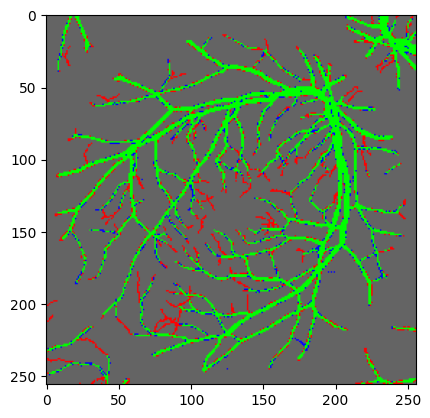

In [91]:
p = pred[1][0].detach().cpu().numpy()
m = msks[1][0].detach().cpu().numpy()
p = np.where(p > 0.5, 1, 0)
m = np.where(m > 0, 1, 0)
im = np.full((256,256,3),100)
# color green where m == p == 1
im[np.where((m==1) & (p==1))] = [0,255,0]
# color red where m == 1 and p == 0
im[np.where((m==1) & (p==0))] = [255,0,0]
# color blue where m == 0 and p == 1
im[np.where((m==0) & (p==1))] = [0,0,255]


# plot the mask
plt.imshow(im)

In [ ]:
def visualize_true_mask(mask,points, p_labels):
    f = Upsample(scale_factor=0.5)

    tru = mask
    
    points = points * 0.5
    lbls = p_labels
    

    tru = f(torch.tensor(tru)[None,None, :, :].float()).numpy()
    tru = tru[0][0]
    
    # plot only true mask
    fig, axs = plt.subplots(1, 1, figsize=(10,10))
    axs.imshow(tru, cmap='gray')
    
    #scatter points
    for i in range(len(points)):
        if lbls[i] == 1:
            axs.scatter(points[i][1], points[i][0], c='blue')#, s = 2)
        else:
            axs.scatter(points[i][1], points[i][0], c='red')#, s = 2)

    

In [ ]:
def visualize_predictions(true_mask, low_res_preds, points, p_labels):
    f = Upsample(scale_factor=0.5)
    # tru = org_data['mask'][0]
    # ponts = org_data['points'][0]
    # ponts = ponts * 0.5
    # lbls = org_data['p_labels'][0]

    tru = true_mask
    ponts = points
    ponts = ponts * 0.5
    lbls = p_labels
    

    tru = f(torch.tensor(tru)[None,None, :, :].float()).numpy()
    tru = tru[0][0]
    preds = low_res_masks[0].detach().cpu().numpy()
    preds = np.where(preds > 0.5, 1, 0)
    print(tru.shape)
    print(preds[0].shape)

    # plot three subplots each for tru and a class prediction
    fig, axs = plt.subplots(3,1)
    fig.suptitle('Predictions for Image 1')
    axs[0,].set_title('Prediction 1')
    tNp = tru + preds[0]*5
    axs[0].imshow(tNp)
    # scatter points   
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[0].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[0].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)


    axs[1].set_title('Prediction 2')
    tNp = tru + preds[1]*5
    axs[1].imshow(tNp)
    # scatter points
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[1].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[1].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)


    axs[2].set_title('Prediction 3')
    tNp = tru + preds[2]*5
    axs[2].imshow(tNp)
    # scatter points with size 2pxs
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[2].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[2].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)
    plt.show()






# # 3 masks for 3 classes
# img1_masks = low_res_masks[0]
# # # # plot low res masks
# plt.imshow(img1_masks[].detach().cpu().numpy())
# plt.show()

-100.0 100.0


Text(0.5, 1.0, 'Blue channel')

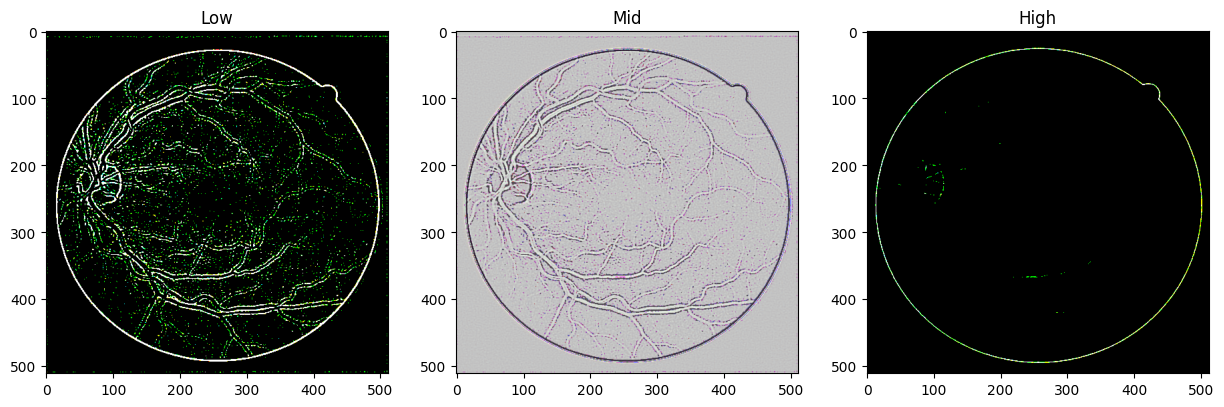

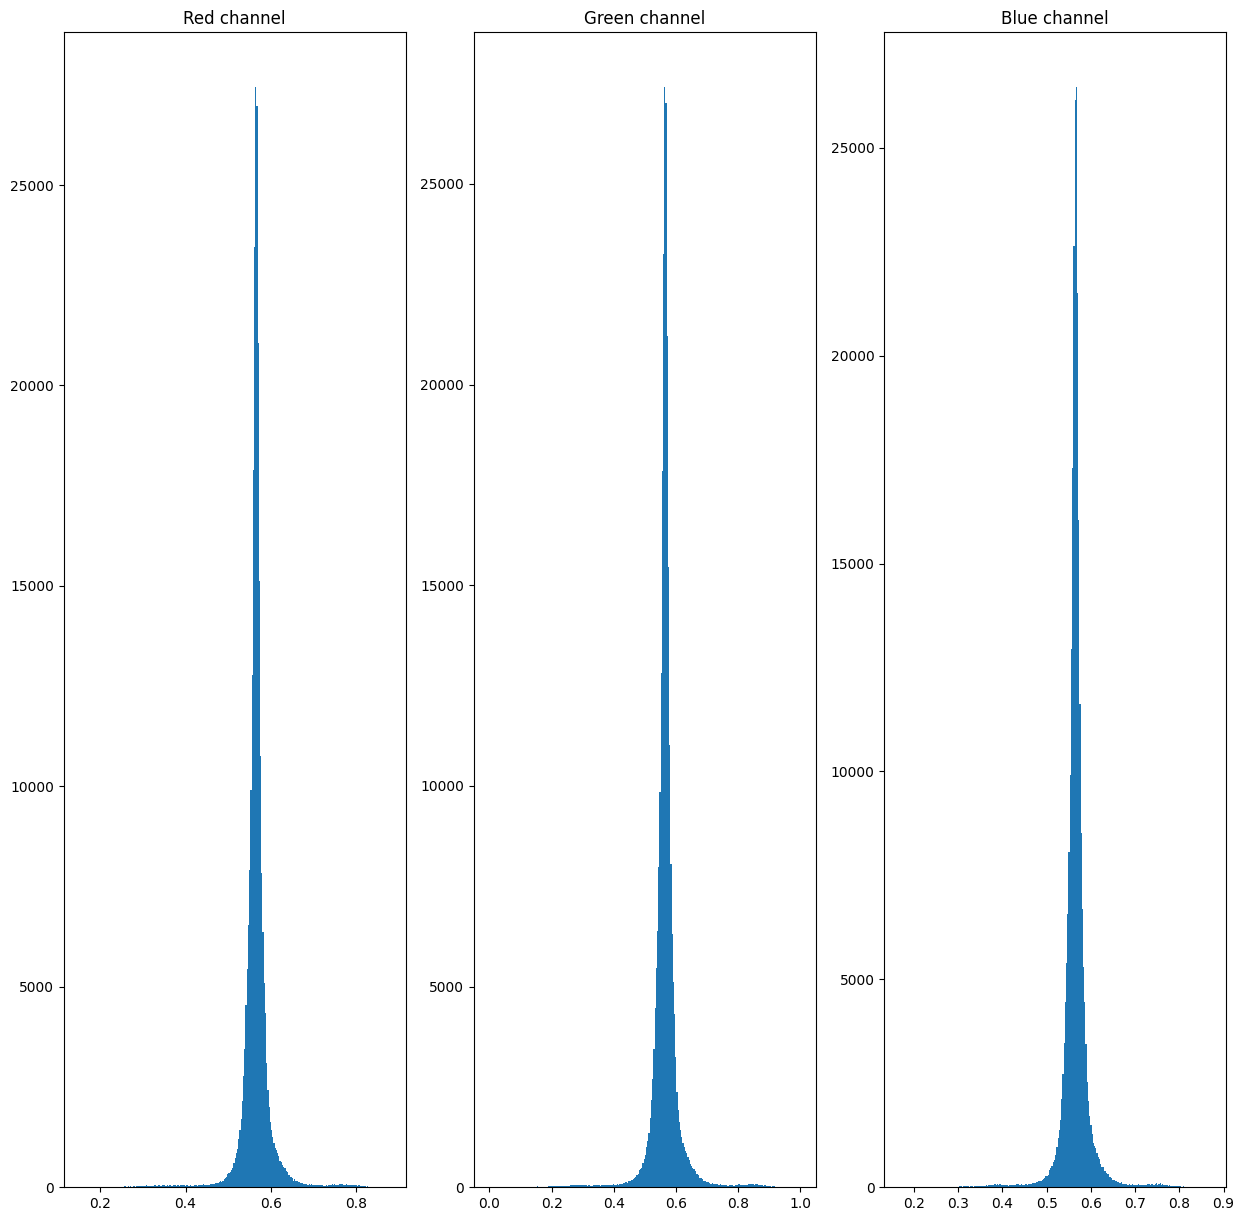

In [133]:
from PIL import Image
import numpy as np


buff = Image.open("data/Data/test/image/0.png")
im  = np.array(buff)

im_org = im.copy()
# apply sobel filter from scipy
from scipy.ndimage import sobel
from skimage import color
# transform image to grayscale

# change im to float
im = im.astype(float)

# Function to find the n'th derivative of an image
def find_n_derivative(im, n, axis):
    im = im.astype(float)
    for i in range(n):
        im = sobel(im, axis=axis, mode='constant')
    return im


#im = color.rgb2gray(im)
im_x = find_n_derivative(im, 2, 1)
im_y = find_n_derivative(im, 2, 0)

# normilize to -100 to 100
im_x = (im_x - im_x.min()) / (im_x.max() - im_x.min())
im_x = im_x * 200 - 100
im_y = (im_y - im_y.min()) / (im_y.max() - im_y.min())
im_y = im_y * 200 - 100
print(im_x.min(),im_x.max())

im_edges = im_x+im_y


#plot histogram of the edges

# normalzie to 0 to 100
im_edges = (im_edges - im_edges.min()) / (im_edges.max() - im_edges.min())


# 55 , 70

low_px = 0.53
high_px = 0.74

cpy = im_edges.copy()


low = np.where(cpy < low_px, 1, 0)

cpy = im_edges.copy()

mid = np.where(cpy > low_px, cpy, 0) + np.where(cpy < high_px, cpy, 0)

cpy = im_edges.copy()

high = np.where(cpy > high_px, 1, 0)


# normalize low, high and mid
low = (low - low.min()) / (low.max() - low.min())
mid = (mid - mid.min()) / (mid.max() - mid.min())
high = (high - high.min()) / (high.max() - high.min())



#plt.imshow(mid)
# plot low, high and mid 
fig, axs = plt.subplots(1,3, figsize=(15,15))
axs[0].imshow(low)
axs[0].set_title('Low')
axs[1].imshow(mid, cmap='gray')
axs[1].set_title('Mid')
axs[2].imshow(high, cmap='gray')
axs[2].set_title('High')



# #visualize in subfigures im_x, im_y, im_edges
# fig, axs = plt.subplots(1,3, figsize=(15,15))
# axs[0].imshow(im_x)
# axs[0].set_title('Sobel X')
# axs[1].imshow(im_y)
# axs[1].set_title('Sobel Y')
# axs[2].imshow(im_edges)
# axs[2].set_title('Sobel X + Y')
# plt.show()

# # opening operation
# from skimage.morphology import opening, disk
# from skimage.filters import threshold_otsu

# #ndimage.binary_erosion

# plot three histogram for each channel of the image
fig, axs = plt.subplots(1,3, figsize=(15,15))
axs[0].hist(im_edges[:,:,0].flatten(), bins=256)
axs[0].set_title('Red channel')
axs[1].hist(im_edges[:,:,1].flatten(), bins=256)
axs[1].set_title('Green channel')
axs[2].hist(im_edges[:,:,2].flatten(), bins=256)
axs[2].set_title('Blue channel')








-100.0 100.0


Text(0.5, 1.0, 'High0.69')

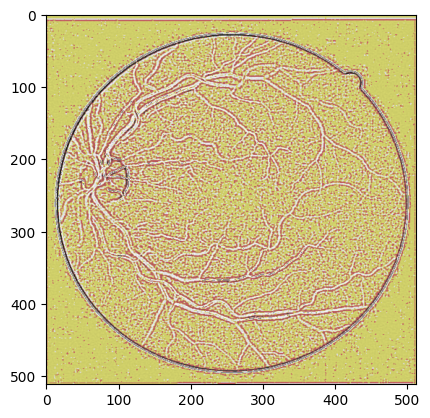

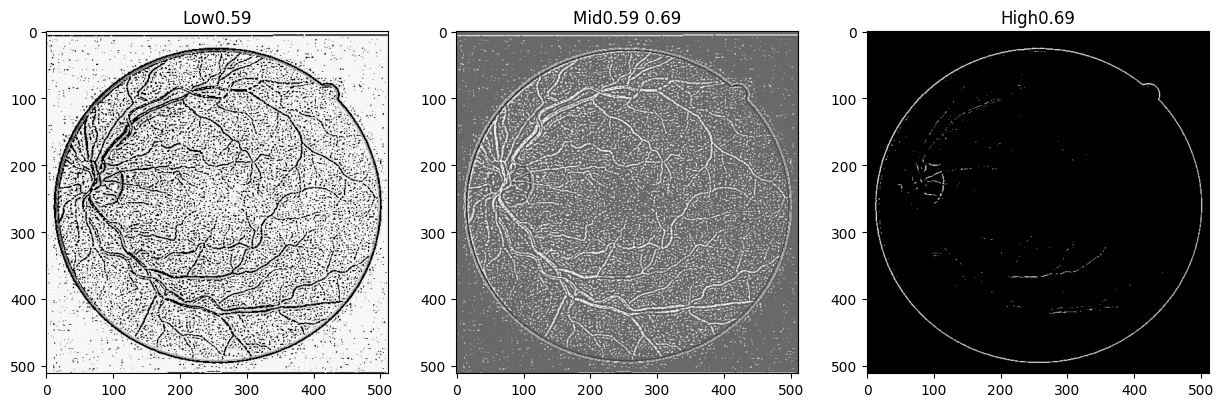

In [83]:
from PIL import Image
import numpy as np
# import plt
import matplotlib.pyplot as plt


buff = Image.open("data/Data/test/image/0.png")
im  = np.array(buff)

im_org = im.copy()
# apply sobel filter from scipy
from scipy.ndimage import sobel
from skimage import color
# transform image to grayscale

# change im to float
im = im.astype(float)

# # # plot histogram for each channel but normlize first
# # fig, axs = plt.subplots(1,3, )#figsize=(15,15))
# # b = im[:,:,0].flatten()
# # g = im[:,:,1].flatten()
# # r = im[:,:,2].flatten()
# # # normalize to 0 to 1
# # b = (b - b.min()) / (b.max() - b.min())
# # g = (g - g.min()) / (g.max() - g.min())
# # r = (r - r.min()) / (r.max() - r.min())
# # axs[0].hist(b, bins=256)
# # axs[0].set_title('Blue channel')
# # axs[1].hist(g, bins=256)
# # axs[1].set_title('Green channel')
# # axs[2].hist(r, bins=256)
# # axs[2].set_title('Red channel')



# Function to find the n'th derivative of an image
def find_n_derivative_in_channel(im, n, axis, channel):
    im = im[:,:,channel]
    im = im.astype(float)
    for i in range(n):
        im = sobel(im, axis=axis, mode='constant')
    return im   


    


#im = color.rgb2gray(im)
im_x = find_n_derivative_in_channel(im, 2, 1 ,2)
im_y = find_n_derivative_in_channel(im, 2, 0, 2)

# normilize to -100 to 100
im_x = (im_x - im_x.min()) / (im_x.max() - im_x.min())
im_x = im_x * 200 - 100
im_y = (im_y - im_y.min()) / (im_y.max() - im_y.min())
im_y = im_y * 200 - 100
print(im_x.min(),im_x.max())

im_edges = im_x+im_y




def extract_info(red_lim, green_lim, blue_lim, im):
    #red
    cpy = im.copy()
    r = np.where(cpy > red_lim[0], cpy, 0) + np.where(cpy < red_lim[1], cpy, 0)
    #normlize to 0 to 255
    r = (r - r.min()) / (r.max() - r.min()) 
    #green
    cpy = im.copy()
    g = np.where(cpy > green_lim[0], cpy, 0) + np.where(cpy < green_lim[1], cpy, 0)
    g = (g - g.min()) / (g.max() - g.min()) 
    #blue
    cpy = im.copy()
    b = np.where(cpy > blue_lim[0], cpy, 0) + np.where(cpy < blue_lim[1], cpy, 0)
    b = (b - b.min()) / (b.max() - b.min()) 
    #return 
    return np.stack([r,g,b], axis=2)

    






# im_edges = im_x+im_y


# #plot histogram of the edges

# # normalzie to 0 to 100
im_edges = (im_edges - im_edges.min()) / (im_edges.max() - im_edges.min())


# # 55 , 70


#red
# low_px = 0.4
# high_px = 0.7

# green
# low_px = 0.55
# high_px = 0.7

# blue
low_px = 0.59
high_px = 0.69


r_lim = [0.4,0.7]
g_lim = [0.55,0.7]
b_lim = [0.59,0.69]

extracted = extract_info(r_lim, g_lim, b_lim, im_edges)

plt.imshow(extracted)



cpy = im_edges.copy()


low = np.where(cpy < low_px, cpy, 0)

cpy = im_edges.copy()

mid = np.where(cpy > low_px, cpy, 0) + np.where(cpy < high_px, cpy, 0)

cpy = im_edges.copy()

high = np.where(cpy > high_px, cpy, 0)


# normalize low, high and mid
low = (low - low.min()) / (low.max() - low.min())
mid = (mid - mid.min()) / (mid.max() - mid.min())
high = (high - high.min()) / (high.max() - high.min())

# #visualize in subfigures im_x, im_y, im_edges
# fig, axs = plt.subplots(1,3, figsize=(15,15))
# axs[0].imshow(im_x)
# axs[0].set_title('Sobel X')
# axs[1].imshow(im_y)
# axs[1].set_title('Sobel Y')
# axs[2].imshow(im_edges)

# visualize low, mid and high
fig, axs = plt.subplots(1,3, figsize=(15,15))
axs[0].imshow(low, cmap='gray')
axs[0].set_title('Low' + str(low_px))
axs[1].imshow(mid, cmap='gray')
axs[1].set_title('Mid' + str(low_px) + ' ' + str(high_px))
axs[2].imshow(high, cmap='gray')
axs[2].set_title('High' + str(high_px))
#plt.show()









[0.         0.00389387 0.00395022 ... 0.99995454 0.99997418 1.        ]


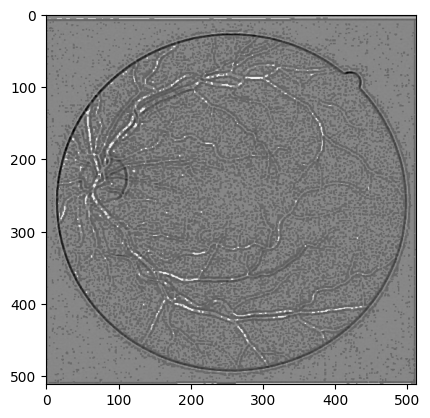

In [113]:
edges = extracted.copy()

# normalize 0 to 255
#edges = (edges - edges.min()) / (edges.max() - edges.min()) * 255


print(np.unique(edges))

from skimage.morphology import disk
from skimage.morphology import binary_erosion, binary_dilation, erosion, dilation

from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters


@adapt_rgb(each_channel)
def sobel_each(image, sh):
    return filters.median(image, sh)   

square = np.ones((2,2))


# edges = binary_erosion(edges, square)
# edges = binary_dilation(edges, square)




# # median filter
from skimage.filters import median
#

edges = erosion(edges,  np.ones((2,2,2)))
edges = sobel_each(edges, disk(1))
edges = sobel_each(edges, disk(1))



# change to grey scale
edges = color.rgb2gray(edges)



# plot
plt.imshow(edges, cmap='gray')